In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


In [108]:
class minimal_network(nn.Module):
    
    def __init__(self, N, input_size = 2, output_size = 1, alpha = 0.001, iterations = 1000):
        super(minimal_network, self).__init__()
        self.fc1 = nn.Linear(input_size, N)
        self.fc2 = nn.Linear(N, output_size)
        self.alpha = alpha
        self.hidden_size = N
        self.iterations = iterations
        
    def init_tuning_curves(self, O1, O2, sigma, color1, color2, plot = True, difference = False):
        x = np.linspace(-20, 20, self.hidden_size)
        def normal_dist(x , mean , sd):
            prob_density = (1/np.sqrt((np.pi*(sd**2))) * np.exp(-0.5*((x-mean)/sd)**2))
            return prob_density
        pdf1 = normal_dist(x, O1, sigma)
        pdf1 = pdf1/np.max(pdf1)
        pdf2 = normal_dist(x, O2, sigma)
        pdf2 = pdf2/np.max(pdf2)
        d = pdf2 - pdf1
        w21 = torch.tensor([pdf1, pdf2]).T
        
        with torch.no_grad():
            self.fc1.weight = torch.nn.Parameter(w21.float())
            self.fc2.weight = torch.nn.Parameter(torch.zeros((1,self.hidden_size)))
        
        if plot == True:
            plt.plot(x, pdf1, color = color1);
            plt.plot(x, pdf2, color = color2);
            plt.xlabel('Angle');
            plt.ylabel('Response');
            
        if difference == True:
            plt.plot(x, d, color = "red")
    
    def input(self, input_matrix):
        self.input = input_matrix
    
    def desired_output(self, output_matrix):
        self.desired_output = output_matrix
            
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out
    
    def loss(self, scores, desired_output):
        loss = torch.linalg.norm(desired_output - scores)**2
        return loss

    def train(self, iterations, optimizer):
        self.losses = []
        for i in range(iterations):
            for j in range(len(self.input)):
                optimizer.zero_grad()
                scores = self.forward(self.input[j])
                loss = self.loss(scores, self.desired_output[j])
                self.losses.append(loss)   
                loss.backward()
                optimizer.step()

    def mean_train(self, iterations, optimizer):
        self.losses = []
        for i in range(iterations):
            loss2 = []
            for j in range(len(self.input)):
                optimizer.zero_grad()
                scores = self.forward(self.input[j])
                loss1 = self.loss(scores, self.desired_output[j])
                loss2.append(loss1)   
            loss = (loss2[0]+loss2[1])/2
            self.losses.append(loss)
            loss.backward()
            optimizer.step()
                
    def plot_loss(self, color):
        plt.plot(self.losses, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")


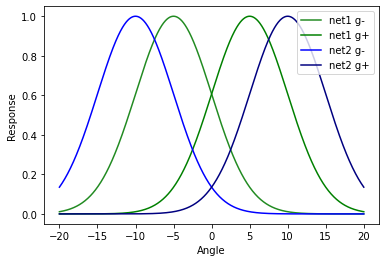

In [125]:
net = minimal_network(1000, alpha = 0.00001)
net.init_tuning_curves(O1 = -5, O2 = 5, sigma = 5, color1 = "forestgreen", color2 = "green", plot = True)
net.input = torch.tensor([[1,0], [0,1]], dtype = torch.float32)
net.desired_output = torch.tensor([1, -1], dtype = torch.float32)
optimizer = optim.SGD(net.parameters(), lr = net.alpha)
net.train(5000, optimizer)


net2 = minimal_network(1000, alpha= 0.00001)
net2.init_tuning_curves(O1 = -10, O2 = 10, sigma = 5, color1 = "blue", color2 = "navy", plot = True)
net2.input = torch.tensor([[1,0], [0,1]], dtype = torch.float32)
net2.desired_output = torch.tensor([1, -1], dtype = torch.float32)
optimizer = optim.SGD(net2.parameters(), lr = net2.alpha)
net2.train(5000, optimizer)

plt.legend(["net1 g-", "net1 g+", "net2 g-", "net2 g+"], loc = 'upper right')

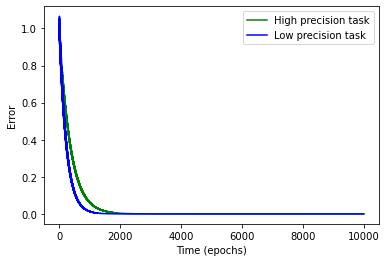

In [126]:
net.plot_loss('green')
net2.plot_loss('blue')
plt.legend(["High precision task", "Low precision task"])

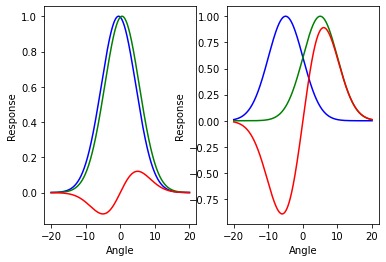

In [100]:
plt.subplot(1, 2, 1)
net = minimal_network(N=1000)
net.init_tuning_curves(O1 = -0.5, O2 = 0.5, sigma = 5, color1 = "blue", color2 = "green", plot = True, difference = True)

plt.subplot(1, 2, 2)
net2 = minimal_network(N=1000)
net2.init_tuning_curves(O1 = -5, O2 = 5, sigma = 5, color1 = "blue", color2 = "green", plot = True, difference = True)

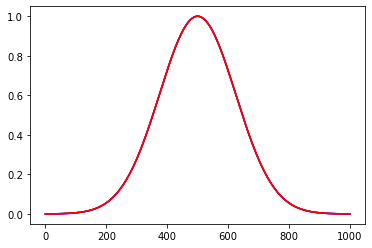

In [21]:
net = minimal_network(1000)
net.init_tuning_curves(O1 = -0.0001, O2 = 0.0001, sigma = 5, color1 = "green", color2 = "green", plot = False)
bleft = []
bright = []
for i in net.fc1.weight:
    bleft.append(i[0])
    bright.append(i[1])
plt.plot(bleft, color = "blue")
plt.plot(bright, color = 'blue')


net.input = torch.tensor([[1,0], [0,1]], dtype = torch.float32)
net.desired_output = torch.tensor([1, -1], dtype = torch.float32)
optimizer = optim.SGD(net.parameters(), lr = net.alpha)
net.train(5000, optimizer)
aleft = []
aright = []
for i in net.fc1.weight:
    aleft.append(i[0])
    aright.append(i[1])


plt.plot(aleft, color = "red")
plt.plot(aright, color = 'red')

